In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import opendatasets as od

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D,Dense, MaxPooling2D,Flatten,Dropout,Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
import datetime
from tensorflow.keras.utils import plot_model

In [5]:
od.download("https://www.kaggle.com/datasets/subhaditya/fer2013plus")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tahakoleilat
Your Kaggle Key: ··········


100%|██████████| 132M/132M [00:01<00:00, 127MB/s]


In [ ]:
emotion = []
instances = []
print("Training images: ")
for expression in os.listdir('/content/fer2013plus/fer2013plus/fer2013/train/'):
    print(str(len(os.listdir('/content/fer2013plus/fer2013plus/fer2013/train/' + expression))) + " " + expression + " images")
    emotion.append(expression)
    instances.append(len(os.listdir('/content/fer2013plus/fer2013plus/fer2013/train/' + expression)))

Training images: 
7528 happiness images
652 fear images
191 disgust images
10308 neutral images
165 contempt images
3562 surprise images
3514 sadness images
2466 anger images


<BarContainer object of 8 artists>

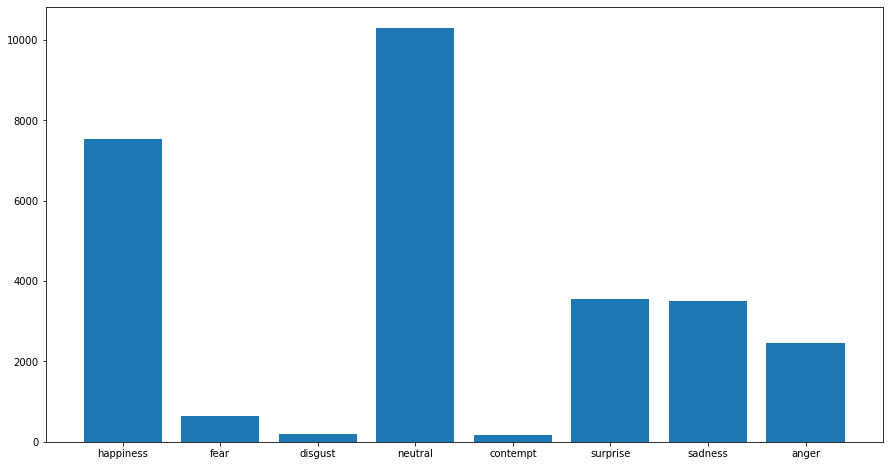

In [ ]:
plt.figure(figsize=(15,8))
plt.bar(emotion,instances)

In [ ]:
emotion2 = []
instances2 = []
print("Testing images: ")
for expression in os.listdir('/content/fer2013plus/fer2013plus/fer2013/test/'):
    print(str(len(os.listdir('/content/fer2013plus/fer2013plus/fer2013/test/' + expression))) + " " + expression + " images")
    emotion2.append(expression)
    instances2.append(len(os.listdir('/content/fer2013plus/fer2013plus/fer2013/test/' + expression)))

Testing images: 
1827 happiness images
167 fear images
57 disgust images
2597 neutral images
51 contempt images
900 surprise images
856 sadness images
644 anger images


<BarContainer object of 8 artists>

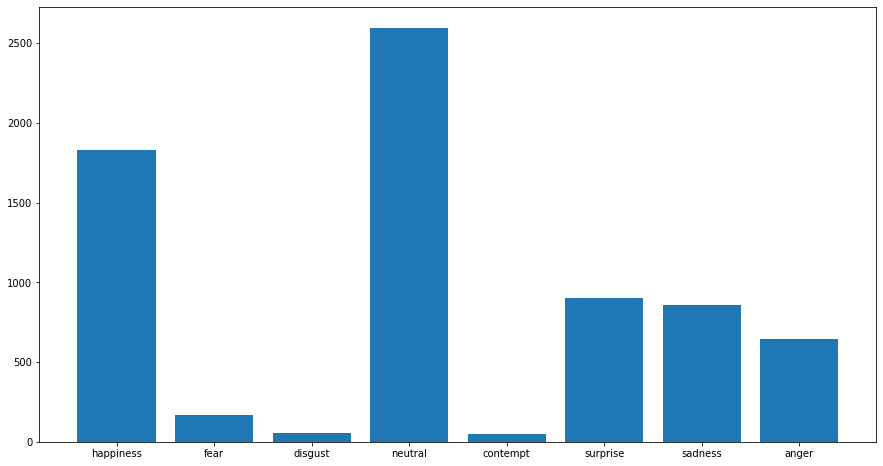

In [ ]:
plt.figure(figsize=(15,8))
plt.bar(emotion2,instances2)

In [2]:
import tensorflow.keras.backend as K
import tensorflow as tf

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
                                   validation_split = 0.2, rotation_range=2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest')

In [4]:
valid_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input,validation_split=0.2)

In [5]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/fer2013plus/fer2013plus/fer2013/train',
                                                   class_mode = 'categorical',
                                                   color_mode="rgb",
                                                    subset="training",
                                                     target_size = (128,128),
                                                   classes={'anger': 0,'disgust': 1,'fear': 2,'happiness': 3,'neutral': 4,'sadness': 5,
                                                             'surprise': 6})
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/fer2013plus/fer2013plus/fer2013/train',
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  color_mode="rgb",
                                                    target_size = (128,128),
                                                  classes={'anger': 0,'disgust': 1,'fear': 2,'happiness': 3,'neutral': 4,'sadness': 5,
                                                             'surprise': 6})

Found 22580 images belonging to 7 classes.
Found 5641 images belonging to 7 classes.


In [6]:
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
test_dataset = test_datagen.flow_from_directory(directory = '/content/fer2013plus/fer2013plus/fer2013/test',
                                                  class_mode = 'categorical',
                                                  color_mode="rgb",
                                                    target_size = (128,128),
                                                 classes={'anger': 0,'disgust': 1,'fear': 2,'happiness': 3,'neutral': 4,'sadness': 5,
                                                             'surprise': 6},shuffle=False)

Found 7048 images belonging to 7 classes.


In [7]:
training_set = train_dataset
valid_set =  valid_dataset
test_set = test_dataset

In [8]:
import numpy as np 
import pandas as pd


import seaborn as sn
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

def build_model(resnet, nodes, drop_rate, activation):
    return Sequential([
        resnet,
        Flatten(),
        Dense(nodes,kernel_initializer='he_uniform'),
        BatchNormalization(),
        Activation('relu'),
        Dropout(drop_rate),
        Dense(7,activation='softmax')
    ])
def train_model(model, epochs, learning_rate):
   checkpoint_filepath = '/tmp/checkpointNew'
   earlyStopping = tf.keras.callbacks.EarlyStopping(
        patience=5,
        monitor="val_accuracy",
        verbose=1,)
   model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
       filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_freq="epoch")
   lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-10)
   adam = keras.optimizers.Adam(learning_rate=learning_rate)
   METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
]
   model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=METRICS)
   history = model.fit(training_set, validation_data = valid_set,validation_steps = 100, batch_size = 512, steps_per_epoch= 200,  epochs = epochs,
                        callbacks=[model_checkpoint_callback,earlyStopping,lrd])
   return history
def plot_metrics(model, history, test):
    print("Accuracy of model on testing data : " , model.evaluate(test_set)[1]*100 , "%")
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" Metrics evaluation of the model ")

    ax1.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'])
    ax1.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'])
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(history.history['loss']) + 1), history.history['loss'])
    ax2.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'])
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(history.history['auc']) + 1), history.history['auc'])
    ax3.plot(range(1, len(history.history['val_auc']) + 1), history.history['val_auc'])
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(history.history['precision']) + 1), history.history['precision'])
    ax4.plot(range(1, len(history.history['val_precision']) + 1), history.history['val_precision'])
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(history.history['recall']) + 1), history.history['recall'])
    ax5.plot(range(1, len(history.history['val_recall']) + 1), history.history['val_recall'])
    ax5.set_title('History of Recall')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('Recall')
    ax5.legend(['training', 'validation'])
    plt.show()
def test_model(model, test_set):
    y_pred = model.predict(test_set)
    y_result = []
    for p in y_pred:
        y_result.append(np.argmax(p))
    
    y_actual = []
    for i in range(len(test_set)):
        for p in test_set[i][1]:
            y_actual.append(np.argmax(p))
    
    print(classification_report(y_actual, y_result))
    
    cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

    plt.figure(figsize = (10, 8))
    sn.heatmap(cm, annot = True, fmt = 'd')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
def CNN(resnet, dense_nodes, drop, activation, epochs, lr):
    model = build_model(resnet50, dense_nodes, drop, activation)
    model.summary()
    
    history = train_model(model, epochs, lr)
    
    plot_metrics(model, history, test_set)
    
    test_model(model, test_set)
    return model


94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0 

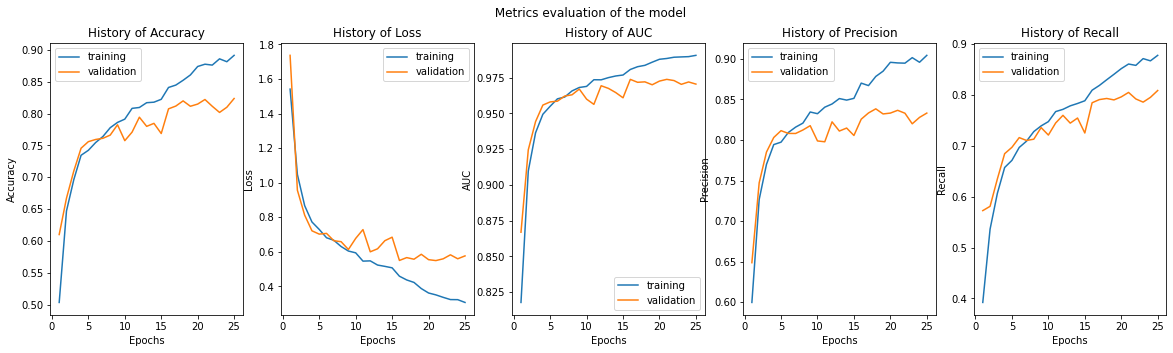

              precision    recall  f1-score   support

           0       0.81      0.73      0.77       644
           1       0.73      0.42      0.53        57
           2       0.61      0.47      0.53       167
           3       0.91      0.92      0.91      1827
           4       0.81      0.90      0.85      2597
           5       0.75      0.55      0.63       856
           6       0.83      0.87      0.85       900

    accuracy                           0.83      7048
   macro avg       0.78      0.70      0.73      7048
weighted avg       0.83      0.83      0.82      7048



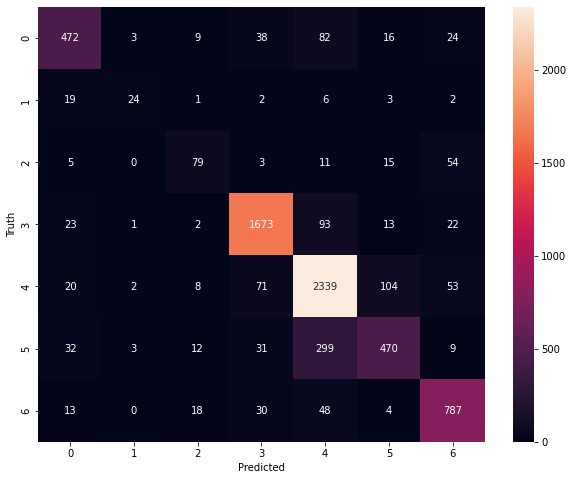

In [13]:
resnet50 = tf.keras.applications.resnet.ResNet50(include_top = False, input_shape = (128, 128, 3), weights = 'imagenet', pooling = "Max")
for layer in resnet50.layers:
    layer.trainable=True
nodes = 256
drop_rate = 0.4
activation = 'softmax'
epochs = 25
lr = 0.0001

model = CNN(resnet50, nodes, drop_rate, activation, epochs, lr)

In [14]:
from keras.models import load_model

model.save('model_weights_new_ferplus.h5')

In [15]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)

In [13]:
x_test=np.concatenate([test_set.next()[0] for i in range(test_set.__len__())])
y_test=np.concatenate([test_set.next()[1] for i in range(test_set.__len__())])
print(x_test.shape)
print(y_test.shape)

(7048, 128, 128, 3)
(7048, 7)


In [14]:
import shap

In [153]:
class_names = ['anger','disgust','fear','happiness','neutral','sadness',
                                                             'surprise']

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:20, 20.77s/it]               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


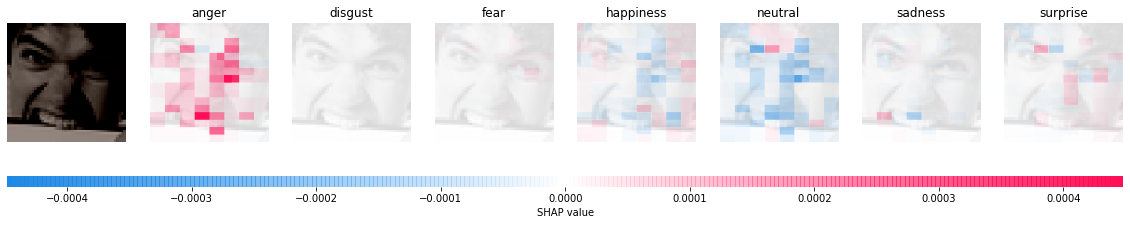

In [172]:
#Reference to the official SHAP documentation https://shap.readthedocs.io/en/latest/example_notebooks/image_examples/image_classification/Image%20Multi%20Class.html
import json 


def predict(x):
    return model(x)

masker = shap.maskers.Image("inpaint_telea", (128,128,3))

explainer = shap.Explainer(predict, masker,algorithm='partition',output_names=class_names)

shap_values = explainer(x_test[[53]], max_evals=1000)

shap.image_plot(shap_values)

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:21, 21.51s/it]               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


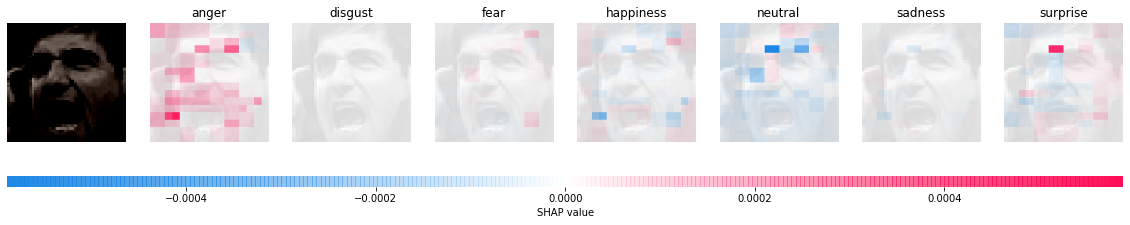

In [173]:
shap_values = explainer(x_test[[13]], max_evals=1000)

shap.image_plot(shap_values)